In [51]:
%load_ext autoreload
%autoreload 2
import sys
import os
project_root = os.path.abspath("")
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import numpy as np 
from pathlib import Path
import utils.metrics_utils
from utils.metrics_utils import * 
from utils.visualization_utils import *
from utils.visualization_utils import _load_tracking_and_behavior
import harp
from ipywidgets import widgets
from IPython.display import display
import moviepy
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Metrics Visualization

In [ ]:
fig, ax = plot_response_times_completed_vs_fa(26, dates=(20250811, 20251010), y_limit=5000)

In [ ]:
figs = plot_fa_ratio_a_over_sessions(26, dates=(20250811, 20251010))

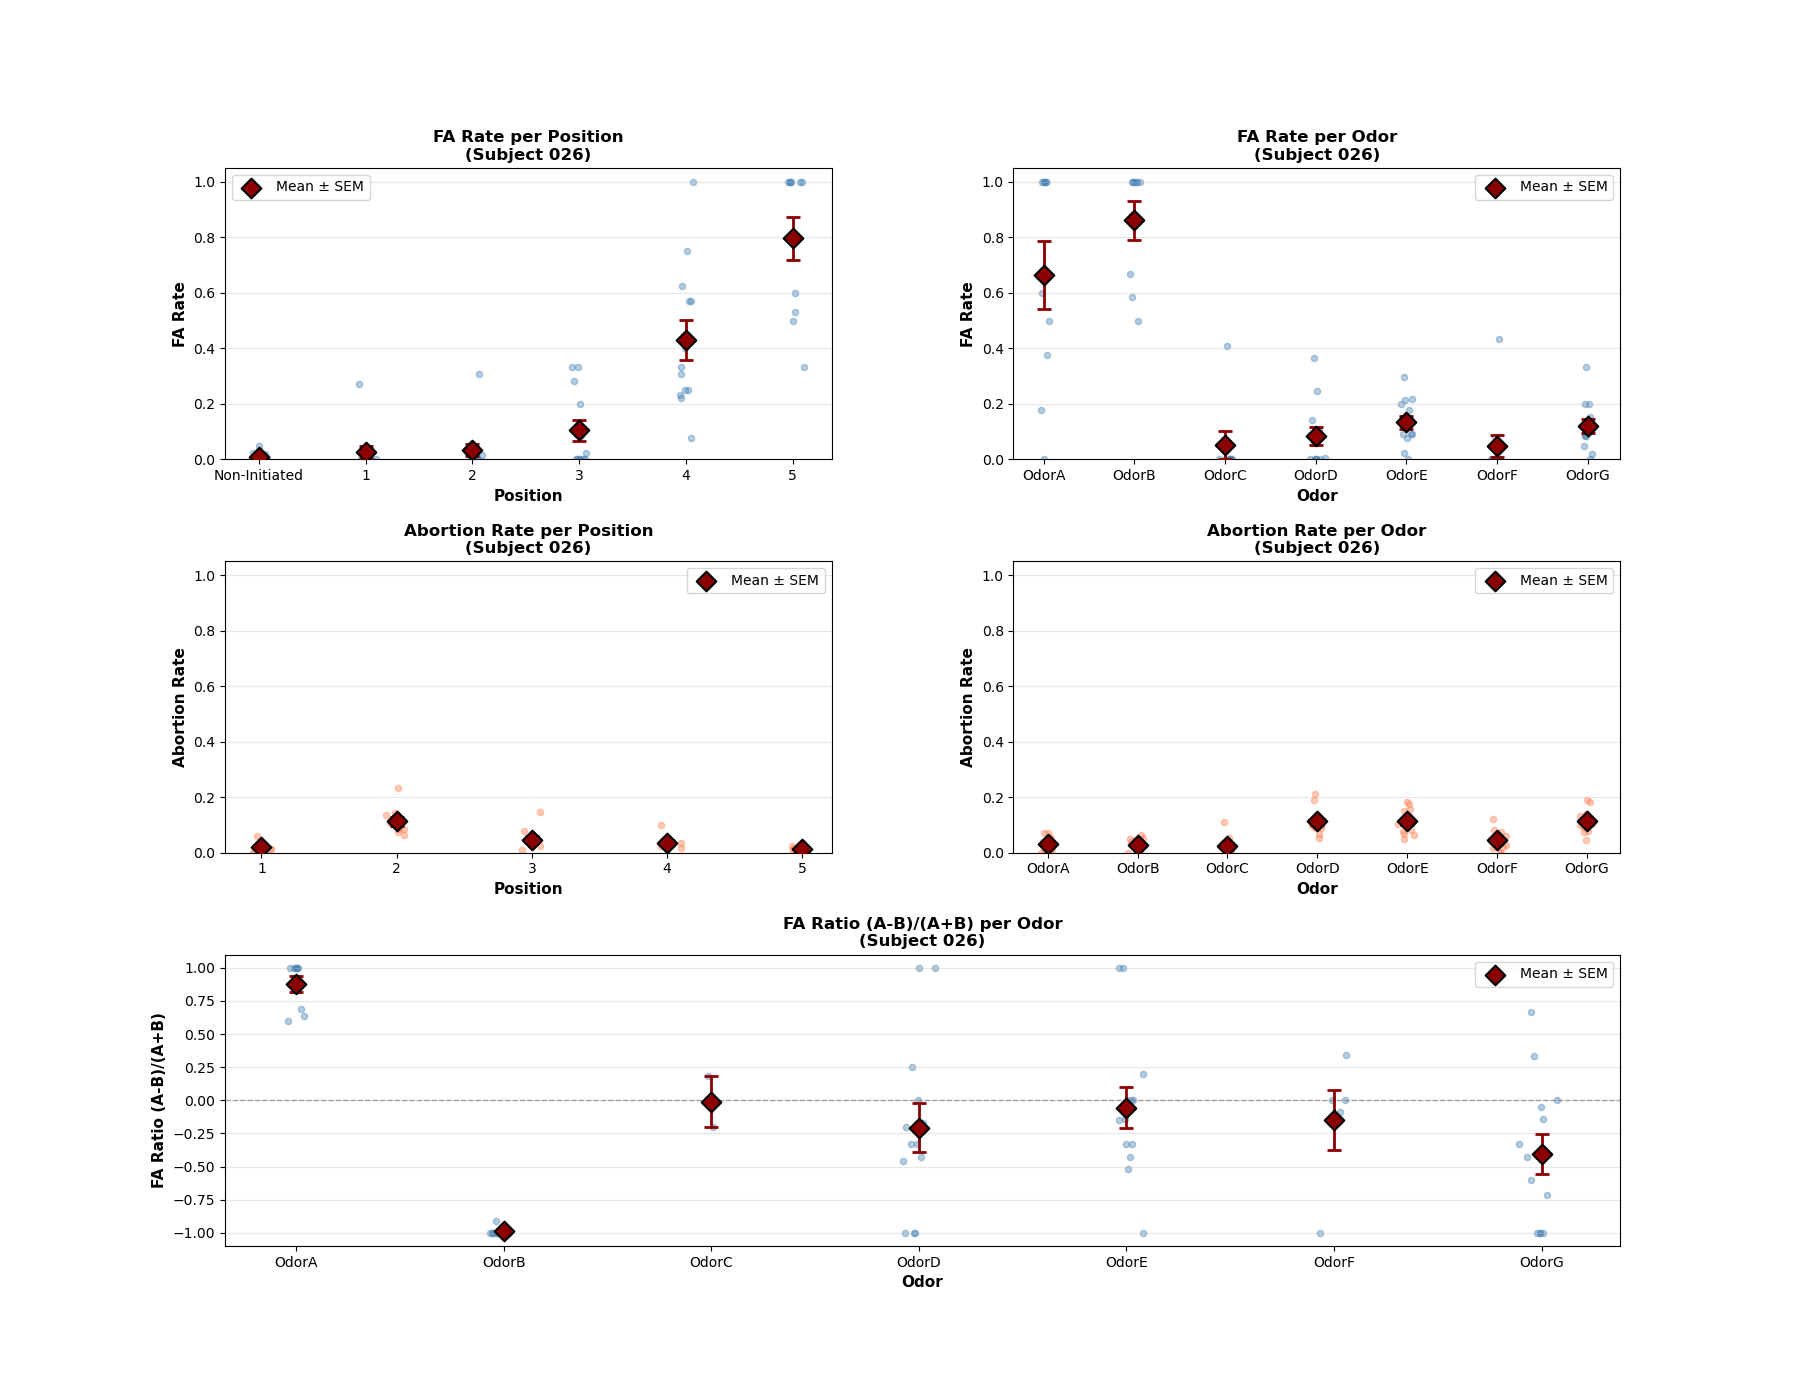

In [49]:
fig, axes = plot_abortion_and_fa_rates(26, dates=(20250916, 20251010), include_noninitiated_in_fa_odor=False, fa_types='FA_time_in,FA_time_out') #can use one or more FA Type filter, or 'All'. E.g., use 'FA_time_in,FA_time_out'

In [ ]:
fig, axes = plot_sampling_times_analysis(26, dates=(20250916, 20251010))

In [ ]:
fig, ax = plot_decision_accuracy_by_odor(26, dates=(20250811, 20251010), plot_choice_acc=True)

In [ ]:
figs = plot_behavior_metrics(
    subjids=[26],
    dates=(20250812, 20250904),
    variables=[
        "hidden_rule_detection_rate"
    ],
    protocol_filter=None,
    compute_if_missing=False, 
    verbose=True
)

# 2. Behavior / Movement analysis

In [ ]:
plot_cumulative_rewards(subjids=[37, 38], dates=(20251028, 20251105), split_days=False)

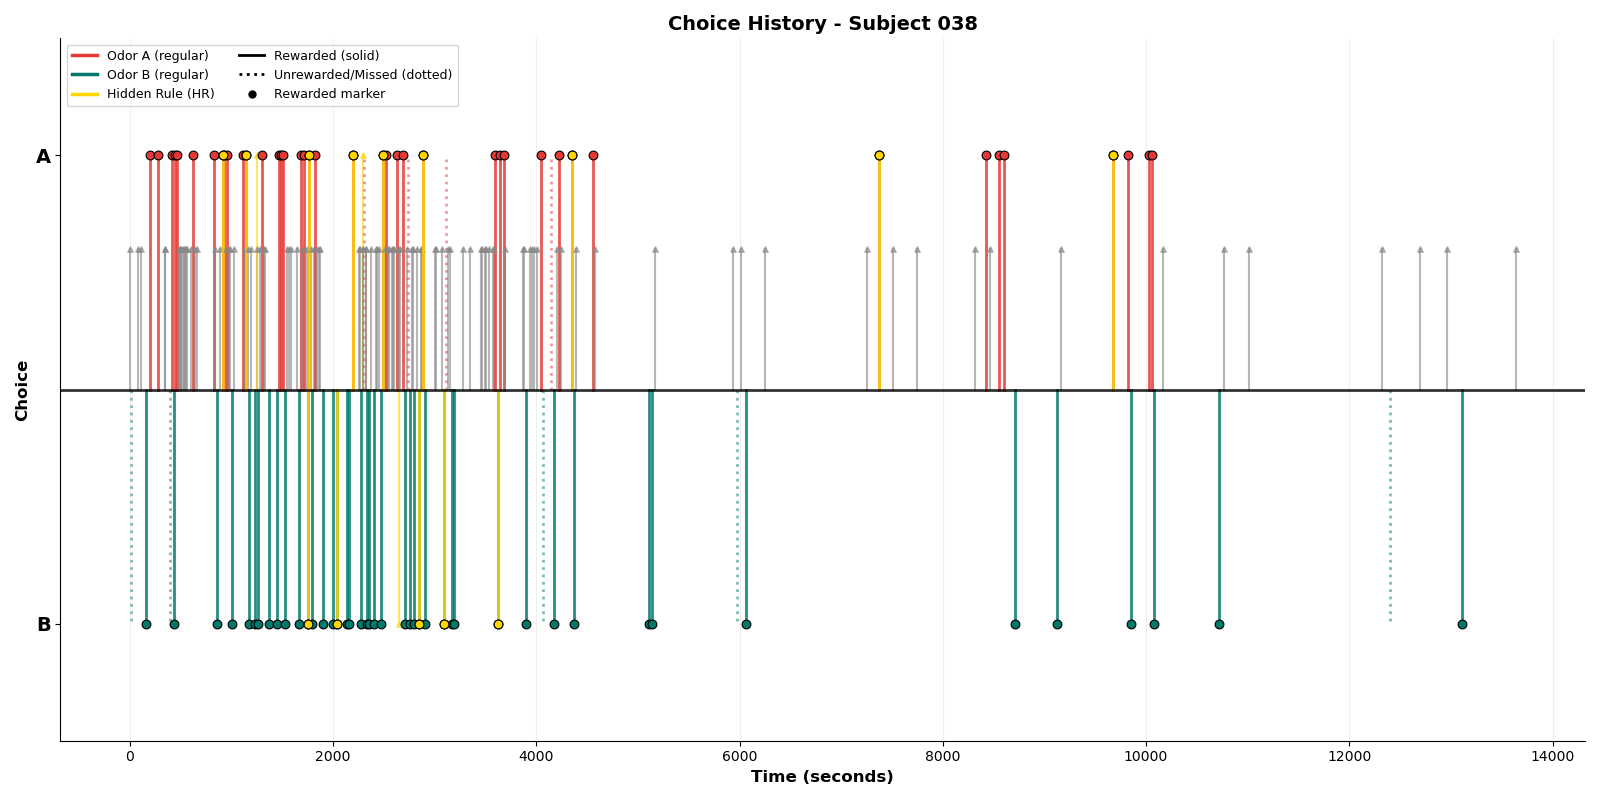

In [18]:
choice_plots = plot_choice_history(subjid=38, dates=[20251120])

In [ ]:
# modes can be simple (all movement), trial_state (within trial vs outside), last_odor (A vs B), trial_windows (one or more trial windows), time_windows (one or more time windows)
# for trial_windows: trial_windows=[(0, 20), (-20, None)] will plot first vs last 20 trials
# for time_windows: time_windows=[("15:20:00","15:25:00"), ("16:00:00","16:05:00")] will plot 2 5-minute windows
plot_movement_with_behavior(38, 20251030, mode='trial_windows_rew', trial_windows=[(0, 10), (-10,None)], xlim=(220,1160), ylim=(10,950))


In [53]:
plt.close('all')

In [ ]:
tracking_times = add_timestamps_to_sleap_tracking(38, 20251029)

In [ ]:
# Annotate Videos with SLEAP Tracking (also adds timestamps and frame numbers)

output_videos = annotate_videos_with_sleap_and_trials(
    subjid=38, 
    date=20251029,
    centroid_radius=8,  
    centroid_color='red'
)

# Debugging


In [55]:
# Debug: Analyze FA on HR trials - extract HR odors from summary.json and create detailed breakdown
from pathlib import Path
import json

subjid = 26
dates = (20250916, 20251010)

base_path = Path(project_root) / "data" / "rawdata"
server_root = base_path.resolve().parent
derivatives_dir = server_root / "derivatives"

print("="*80)
print(f"FA ON HIDDEN RULE TRIALS ANALYSIS - Subject {subjid}, Dates {dates[0]}-{dates[1]}")
print("="*80)

from utils.visualization_utils import _iter_subject_dirs, _filter_session_dirs

# Store summary results
summary_results = []

for sid, subj_dir in _iter_subject_dirs(derivatives_dir, [subjid]):
    ses_dirs = _filter_session_dirs(subj_dir, dates)
    
    for ses in ses_dirs:
        date_str = ses.name.split("_date-")[-1]
        results_dir = ses / "saved_analysis_results"
        
        if not results_dir.exists():
            continue
        
        hr_path = results_dir / "aborted_sequences_HR.csv"
        ab_det_path = results_dir / "aborted_sequences_detailed.csv"
        summary_path = results_dir / "summary.json"
        
        if not hr_path.exists() or not ab_det_path.exists() or not summary_path.exists():
            if not hr_path.exists():
                print(f"\nDate {date_str}: No HR file")
            if not ab_det_path.exists():
                print(f"\nDate {date_str}: No aborted_sequences_detailed.csv")
            if not summary_path.exists():
                print(f"\nDate {date_str}: No summary.json")
            continue
        
        print(f"\n--- Date: {date_str} ---")
        
        try:
            # Load summary to get HR odors
            with open(summary_path) as f:
                summary = json.load(f)
            
            hr_odors = summary.get("params", {}).get("hidden_rule_odors", [])
            print(f"Hidden rule odors: {hr_odors}")
            
            if len(hr_odors) < 2:
                print(f"  Warning: Expected 2 HR odors, found {len(hr_odors)}")
            
            hr_odor_1 = hr_odors[0] if len(hr_odors) > 0 else None
            hr_odor_2 = hr_odors[1] if len(hr_odors) > 1 else None
            
            # Load data
            df_hr = pd.read_csv(hr_path)
            df_ab = pd.read_csv(ab_det_path)
            
            n_hr_trials = len(df_hr)
            print(f"\nHR trials: {n_hr_trials}")
            print(f"Aborted sequences with details: {len(df_ab)}")
            
            # Match HR trials with aborted sequences
            if "sequence_start" in df_hr.columns and "sequence_start" in df_ab.columns:
                hr_with_fa = df_hr[df_hr["sequence_start"].isin(df_ab["sequence_start"])].copy()
                n_matched = len(hr_with_fa)
                print(f"\nMatched HR trials (any abort reason): {n_matched}")
                
                # Merge to get FA details - include last_odor_position from aborted_sequences_detailed
                merged = hr_with_fa.merge(
                    df_ab[["sequence_start", "fa_label", "last_odor_name", "fa_port", "last_odor_position"]],
                    on="sequence_start",
                    how="left"
                )
                # Add HR position info and odor_sequence from HR data
                hr_cols_to_merge = ["sequence_start"]
                if "hidden_rule_positions" in df_hr.columns:
                    hr_cols_to_merge.append("hidden_rule_positions")
                if "odor_sequence" in df_hr.columns:
                    hr_cols_to_merge.append("odor_sequence")
                
                if len(hr_cols_to_merge) > 1:
                    merged = merged.merge(
                        df_hr[hr_cols_to_merge],
                        on="sequence_start",
                        how="left",
                        suffixes=('', '_hr')
                    )
                
                # Filter for actual FAs (not nFA)
                merged_fa = merged[merged["fa_label"] != "nFA"].copy()
                n_fa_trials = len(merged_fa)
                print(f"Matched HR trials ending in FA (!= nFA): {n_fa_trials}")
                
                # Helper function to count port A vs B
                def count_ports(data):
                    port_a = (data["fa_port"] == 1).sum()
                    port_b = (data["fa_port"] == 2).sum()
                    total = port_a + port_b
                    return int(port_a), int(port_b), int(total)
                
                # Helper function to extract HR position from hidden_rule_positions
                def get_hr_position(hr_pos_str):
                    """Extract first HR position from hidden_rule_positions JSON string"""
                    if pd.isna(hr_pos_str):
                        return None
                    try:
                        import json
                        pos_list = json.loads(str(hr_pos_str))
                        if isinstance(pos_list, list) and len(pos_list) > 0:
                            return int(pos_list[0])
                        return None
                    except:
                        return None
                
                # Analysis for each HR odor
                print(f"\n{'FA Analysis by Hidden Rule Odor Position':^80}")
                print("="*80)
                
                for odor_num, hr_odor in enumerate([hr_odor_1, hr_odor_2], 1):
                    if hr_odor is None:
                        continue
                    
                    print(f"\n--- HR ODOR {odor_num}: {hr_odor} ---")
                    
                    # Filter merged_fa to only trials where this HR odor is the hidden rule
                    # by checking if this HR odor appears in the odor_sequence
                    def has_hr_odor_in_sequence(odor_seq):
                        if pd.isna(odor_seq):
                            return False
                        try:
                            seq_list = json.loads(str(odor_seq))
                            return hr_odor in seq_list if isinstance(seq_list, list) else False
                        except:
                            return hr_odor in str(odor_seq)
                    
                    # Get trials where this HR odor is in the sequence
                    if "odor_sequence" in merged_fa.columns:
                        fa_for_this_hr = merged_fa[merged_fa["odor_sequence"].apply(has_hr_odor_in_sequence)].copy()
                    else:
                        fa_for_this_hr = merged_fa.copy()
                    
                    if len(fa_for_this_hr) == 0:
                        print(f"  No FAs found for HR odor {hr_odor}")
                        continue
                    
                    # Extract HR position for each trial
                    fa_for_this_hr["hr_position"] = fa_for_this_hr["hidden_rule_positions"].apply(get_hr_position)
                    
                    # Group 1: FA on HR odor itself (last_odor_name = HR odor AND last_odor_position = HR position)
                    fa_on_hr_odor = fa_for_this_hr[
                        (fa_for_this_hr["last_odor_name"] == hr_odor) & 
                        (fa_for_this_hr["last_odor_position"] == fa_for_this_hr["hr_position"])
                    ].copy()
                    a1, b1, t1 = count_ports(fa_on_hr_odor)
                    ratio1 = (a1 - b1) / t1 if t1 > 0 else np.nan
                    print(f"\n  FA on HR Odor ({hr_odor}) at HR position:")
                    print(f"    Count: {t1}, Port A: {a1}, Port B: {b1}")
                    if t1 > 0:
                        print(f"    Ratio (A-B)/(A+B): {ratio1:.3f}")
                    summary_results.append({
                        "date": date_str,
                        "metric": f"FA on {hr_odor}",
                        "count": t1,
                        "port_a": a1,
                        "port_b": b1,
                        "ratio": ratio1
                    })
                    
                    # Group 2: FA on 1 position after HR position
                    # This means: last_odor_position = HR_position + 1
                    fa_one_after_hr = fa_for_this_hr[
                        (fa_for_this_hr["last_odor_position"] == fa_for_this_hr["hr_position"] + 1) &
                        (fa_for_this_hr["hr_position"].notna())
                    ].copy()
                    if not fa_one_after_hr.empty:
                        a2, b2, t2 = count_ports(fa_one_after_hr)
                    else:
                        a2, b2, t2 = 0, 0, 0
                    ratio2 = (a2 - b2) / t2 if t2 > 0 else np.nan
                    print(f"\n  FA on 1 position after HR Odor ({hr_odor}):")
                    print(f"    Count: {t2}, Port A: {a2}, Port B: {b2}")
                    if t2 > 0:
                        print(f"    Ratio (A-B)/(A+B): {ratio2:.3f}")
                    summary_results.append({
                        "date": date_str,
                        "metric": f"FA 1 pos after {hr_odor}",
                        "count": t2,
                        "port_a": a2,
                        "port_b": b2,
                        "ratio": ratio2
                    })
                    
                    # Group 3: Total FA at any position >= HR position (in sequences with this HR odor)
                    fa_after_hr = fa_for_this_hr[
                        (fa_for_this_hr["last_odor_position"] >= fa_for_this_hr["hr_position"]) &
                        (fa_for_this_hr["hr_position"].notna())
                    ].copy()
                    if not fa_after_hr.empty:
                        a3, b3, t3 = count_ports(fa_after_hr)
                    else:
                        a3, b3, t3 = 0, 0, 0
                    ratio3 = (a3 - b3) / t3 if t3 > 0 else np.nan
                    print(f"\n  Total FA at/after HR Odor ({hr_odor}) position:")
                    print(f"    Count: {t3}, Port A: {a3}, Port B: {b3}")
                    if t3 > 0:
                        print(f"    Ratio (A-B)/(A+B): {ratio3:.3f}")
                    summary_results.append({
                        "date": date_str,
                        "metric": f"FA after {hr_odor} total",
                        "count": t3,
                        "port_a": a3,
                        "port_b": b3,
                        "ratio": ratio3
                    })
            
            print("\n" + "-"*80)
                    
        except Exception as e:
            print(f"Error processing date {date_str}: {e}")
            import traceback
            traceback.print_exc()

print("\n" + "="*80)
print("SUMMARY - ALL RESULTS SORTED BY METRIC, THEN BY RATIO (Ascending)")
print("="*80)

if summary_results:
    # Create DataFrame and sort by metric first, then by ratio (ascending, -1 to 1)
    df_summary = pd.DataFrame(summary_results)
    df_summary = df_summary.sort_values(by=["metric", "ratio"], na_position='last')
    
    # Display with nice formatting
    print("\n{:<12} {:<25} {:<8} {:<8} {:<8} {:<12}".format(
        "Date", "Metric", "Count", "Port A", "Port B", "Ratio"
    ))
    print("-" * 80)
    
    for _, row in df_summary.iterrows():
        ratio_str = f"{row['ratio']:.3f}" if pd.notna(row['ratio']) else "N/A"
        print("{:<12} {:<25} {:<8} {:<8} {:<8} {:<12}".format(
            row['date'], 
            row['metric'], 
            int(row['count']), 
            int(row['port_a']), 
            int(row['port_b']), 
            ratio_str
        ))
    
    print("\n" + "="*80)
    print("STATISTICS BY METRIC")
    print("="*80)
    
    for metric in sorted(df_summary['metric'].unique()):
        metric_data = df_summary[df_summary['metric'] == metric]
        valid_ratios = metric_data['ratio'].dropna()
        
        if len(valid_ratios) > 0:
            print(f"\n{metric}:")
            print(f"  Sessions with data: {len(valid_ratios)}")
            print(f"  Mean ratio: {valid_ratios.mean():.3f}")
            print(f"  Min ratio: {valid_ratios.min():.3f}")
            print(f"  Max ratio: {valid_ratios.max():.3f}")
            print(f"  Std Dev: {valid_ratios.std():.3f}")
else:
    print("No data collected")

print("\n" + "="*80)
print("DONE")
print("="*80)

FA ON HIDDEN RULE TRIALS ANALYSIS - Subject 26, Dates 20250916-20251010

--- Date: 20250916 ---
Hidden rule odors: ['OdorC', 'OdorF']

HR trials: 59
Aborted sequences with details: 59

Matched HR trials (any abort reason): 59
Matched HR trials ending in FA (!= nFA): 53

                    FA Analysis by Hidden Rule Odor Position                    

--- HR ODOR 1: OdorC ---

  FA on HR Odor (OdorC) at HR position:
    Count: 3, Port A: 2, Port B: 1
    Ratio (A-B)/(A+B): 0.333

  FA on 1 position after HR Odor (OdorC):
    Count: 18, Port A: 6, Port B: 12
    Ratio (A-B)/(A+B): -0.333

  Total FA at/after HR Odor (OdorC) position:
    Count: 25, Port A: 10, Port B: 15
    Ratio (A-B)/(A+B): -0.200

--- HR ODOR 2: OdorF ---

  FA on HR Odor (OdorF) at HR position:
    Count: 0, Port A: 0, Port B: 0

  FA on 1 position after HR Odor (OdorF):
    Count: 16, Port A: 7, Port B: 9
    Ratio (A-B)/(A+B): -0.125

  Total FA at/after HR Odor (OdorF) position:
    Count: 28, Port A: 13, Port B:


SUMMARY TABLE (SORTED BY METRIC, THEN BY RATIO)
    date              metric  port_a  port_b  total  ratio
20250923 OdorA - After OdorA       0       0      0    N/A
20250929 OdorA - After OdorA       0       0      0    N/A
20250923    OdorA - On OdorA      10       3     13 +0.538
20250929    OdorA - On OdorA       4       1      5 +0.600
20250929 OdorA - Total OdorA       7       5     12 +0.167
20250923 OdorA - Total OdorA      15       4     19 +0.579
20250923 OdorB - After OdorB       0       2      2 -1.000
20250929 OdorB - After OdorB       0       0      0    N/A
20250923    OdorB - On OdorB       0       6      6 -1.000
20250929    OdorB - On OdorB       0       0      0    N/A
20250923 OdorB - Total OdorB       0      19     19 -1.000
20250929 OdorB - Total OdorB       0       3      3 -1.000
20250929 OdorC - After OdorC      20      93    113 -0.646
20250916 OdorC - After OdorC       6      12     18 -0.333
20251003 OdorC - After OdorC       5       9     14 -0.286
2025091

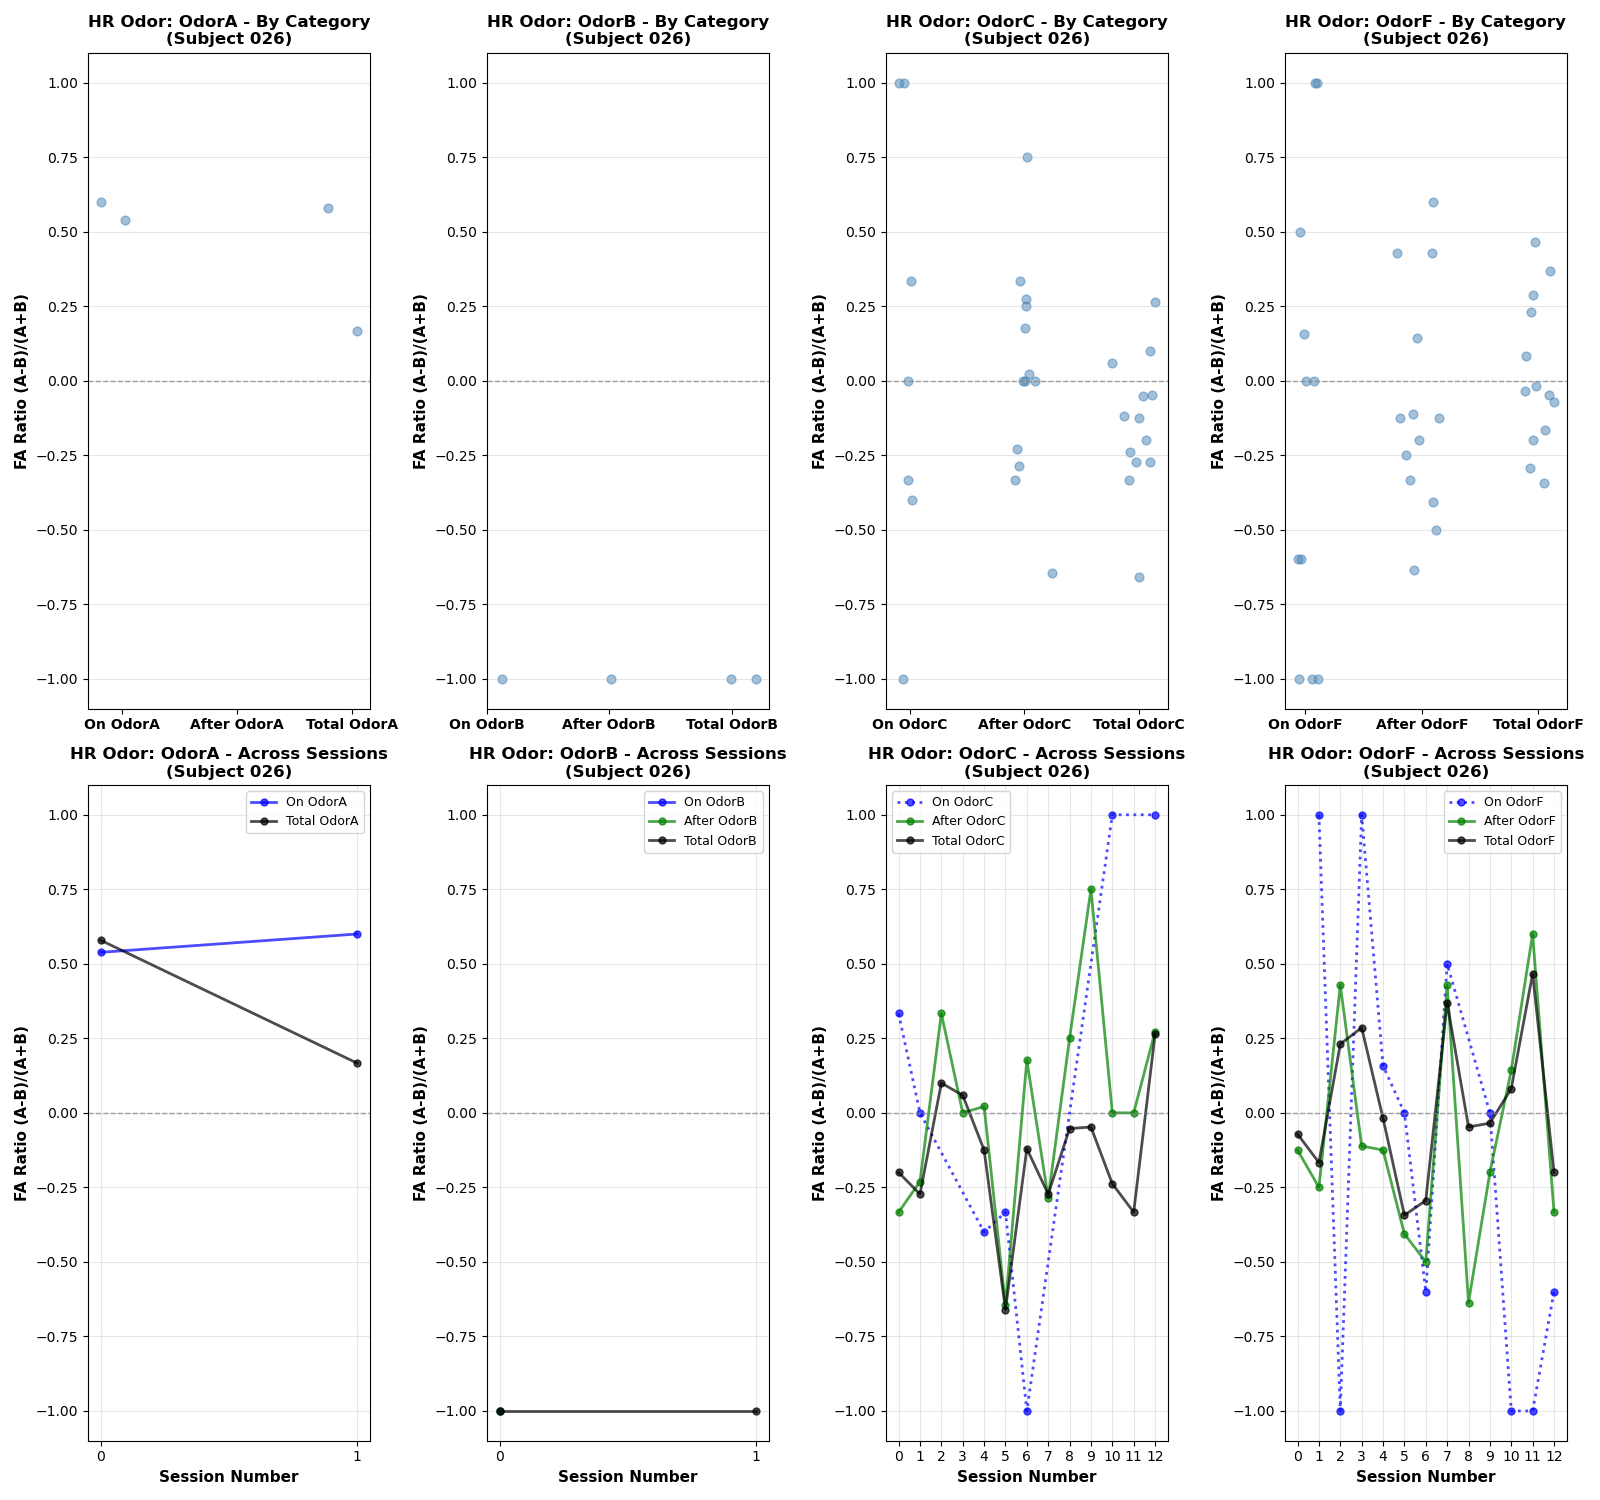

In [63]:
# Plot FA Ratio by Hidden Rule Odor Position
# Can filter by FA types: 'FA_time_in', 'FA_time_out', 'FA_late', or combinations like 'FA_time_in,FA_time_out'
fig, axes = plot_fa_ratio_by_hr_position(26, dates=(20250916, 20251010), fa_types='All', print_statistics=True)
